# 라이브러리

In [1]:
import tensorflow as tf
import torch

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from scipy.special import softmax

import pandas as pd
import numpy as np
import random
import time
import datetime

<br>
<br>

# **데이터 로드**

In [2]:
# 네이버 영화리뷰 감정분석 데이터 다운로드
!git clone https://github.com/e9t/nsmc.git

fatal: destination path 'nsmc' already exists and is not an empty directory.


In [3]:
train = pd.read_csv("nsmc/ratings_train.txt", sep='\t')
test = pd.read_csv("nsmc/ratings_test.txt", sep='\t')

print(train.shape)
print(test.shape)

(150000, 3)
(50000, 3)


In [4]:
# 데이터 구성 확인
train.head(10)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,1


<br>
<br>

# **전처리 - 훈련셋**

In [5]:
# 리뷰 문장 추출
sentences = train['document']

In [6]:
# 라벨 추출
labels = train['label'].values

In [7]:
# 배치 크기
batch_size = 32

# BERT의 입력 형식에 맞게 변환
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]

# BERT의 토큰화기를 사용하여 문장을 토큰화
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

# 입력 토큰의 최대 길이
MAX_LEN = 128

# 토큰을 숫자 인덱스로 변환
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# 최대 길이(MAX_LEN)에 맞게 시퀀스를 패딩하고 부족한 부분은 0으로 채움
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# 어텐션 마스크 초기화
attention_masks = []

# 패딩이 아닌 토큰에 대해 어텐션 마스크를 1로 설정하고 패딩 토큰에 대해 0으로 설정
for seq in input_ids:
    seq_mask = [float(i > 0) for i in seq]
    attention_masks.append(seq_mask)

# 훈련 세트와 검증 세트로 분리
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=1234, test_size=0.1)

# 어텐션 마스크도 훈련 세트와 검증 세트로 분리
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=1234, test_size=0.1)

# 데이터를 파이토치 텐서로 변환
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)



# 입력, 마스크 및 라벨을 파이토치 DataLoader와 연결
# 훈련 중에 배치 크기만큼 데이터를 검색할 수 있도록 함
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

<br>
<br>

# **전처리 - 테스트셋**

In [8]:
sentences = test['document']

In [9]:
labels = test['label'].values

In [10]:
# 배치 사이즈
batch_size = 32

#BERT의 입력 형식에 맞게 변환
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]

# BERT의 토큰화기를 사용하여 문장을 토큰화
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

# 입력 토큰의 최대 길이
MAX_LEN = 128

# 토큰을 숫자 인덱스로 변환
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# 최대 길이(MAX_LEN)에 맞게 시퀀스를 패딩하고 부족한 부분은 0으로 채움
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

attention_masks = []

for seq in input_ids:
    seq_mask = [float(i > 0) for i in seq]
    attention_masks.append(seq_mask)

# 데이터를 파이토치의 텐서로 변환
test_inputs = torch.tensor(input_ids)
test_labels = torch.tensor(labels)
test_masks = torch.tensor(attention_masks)


test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


<br>
<br>

# **모델 및 파라미터 생성**

In [11]:
# GPU 디바이스 이름 구함
device_name = tf.test.gpu_device_name()

# GPU 디바이스 이름 검사
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [12]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Wed_Feb__8_05:53:42_Coordinated_Universal_Time_2023
Cuda compilation tools, release 12.1, V12.1.66
Build cuda_12.1.r12.1/compiler.32415258_0


In [13]:
# 디바이스 정의 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
# 분류를 위한 BERT 모델 생성
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [15]:
# 옵티마이저 설정
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # 학습률
                  eps = 1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값
                )

# 에폭수
epochs = 10

# 총 훈련 스텝 : 배치반복 횟수 * 에폭
total_steps = len(train_dataloader) * epochs

# 처음에 학습률을 조금씩 변화시키는 스케줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

<br>
<br>

# **모델 학습**

In [16]:
# 정확도 계산 함수
def flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=0).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [17]:
# 시간 표시 함수
def format_time(elapsed):

    # 반올림
    elapsed_rounded = int(round((elapsed)))
    
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))


======== Epoch 1 / 10 =======
Training...


C:\Users\CHAMJ\anaconda3\envs\py3_9\lib\site-packages\transformers\optimization.py:146: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\python_arg_parser.cpp:1519.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


 Batch   500 of 4,219. Elapsed: 0:01:36.
 Batch 1,000 of 4,219. Elapsed: 0:03:12.
 Batch 1,500 of 4,219. Elapsed: 0:04:49.
 Batch 2,000 of 4,219. Elapsed: 0:06:26.
 Batch 2,500 of 4,219. Elapsed: 0:08:03.
 Batch 3,000 of 4,219. Elapsed: 0:09:40.
 Batch 3,500 of 4,219. Elapsed: 0:11:17.
 Batch 4,000 of 4,219. Elapsed: 0:12:54.

 Average training loss: 0.38
 Training epoch took: 0:13:36

Running Validation...
Validation Loss: 0.33
Validation Accuracy: 0.50

======== Epoch 2 / 10 =======
Training...
 Batch   500 of 4,219. Elapsed: 0:01:37.
 Batch 1,000 of 4,219. Elapsed: 0:03:14.
 Batch 1,500 of 4,219. Elapsed: 0:04:51.
 Batch 2,000 of 4,219. Elapsed: 0:06:28.
 Batch 2,500 of 4,219. Elapsed: 0:08:04.
 Batch 3,000 of 4,219. Elapsed: 0:09:41.
 Batch 3,500 of 4,219. Elapsed: 0:11:18.
 Batch 4,000 of 4,219. Elapsed: 0:12:55.

 Average training loss: 0.30
 Training epoch took: 0:13:37

Running Validation...
Validation Loss: 0.37
Validation Accuracy: 0.50

======== Epoch 3 / 10 =======
Training

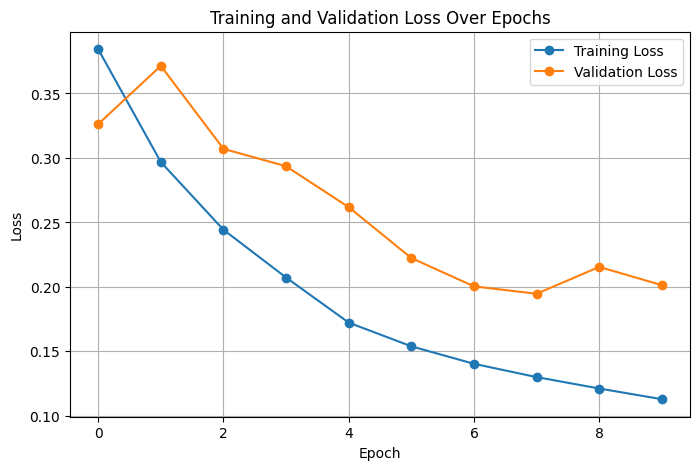

In [18]:
import random
import numpy as np
import torch
import time
import matplotlib.pyplot as plt

# Set a fixed random seed
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Initialize gradients
model.zero_grad()

# Define parameters for early stopping based on validation loss
early_stopping_patience = 2
best_validation_loss = float('inf')
patience = early_stopping_patience

# Initialize the best accuracy
best_accuracy = 0.0

# Lists to store training and validation losses
training_losses = []  
validation_losses = []

# Initialize variables for accuracy calculation
eval_loss, eval_accuracy = 0, 0
nb_eval_steps = 0

# Repeat for a certain number of epochs
for epoch_i in range(0, epochs):

    # =======================================================
    # Training
    # =======================================================
    print("")
    print('======== Epoch {:} / {:} ======='.format(epoch_i + 1, epochs))
    print('Training...')

    # Set start time
    t0 = time.time()

    # Initialize total loss
    total_loss = 0

    # Switch to training mode
    model.train()

    # Repeatedly fetch batches from the data loader
    for step, batch in enumerate(train_dataloader):
        # Display progress information
        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print(' Batch {:>5,} of {:>5,}. Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Put the batch on the GPU
        batch = tuple(t.to(device) for t in batch)

        # Extract data from the batch
        b_input_ids, b_input_mask, b_labels = batch

        # Perform Forward
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)

        # Get the loss
        loss = outputs[0]

        # Calculate the total loss
        total_loss += loss.item()

        # Compute gradients by performing a backward pass
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update model's parameters using the gradients
        optimizer.step()

        # Initialize gradients
        model.zero_grad()

    # Calculate the average training loss
    avg_train_loss = total_loss / len(train_dataloader)
    training_losses.append(avg_train_loss)

    print("")
    print(" Average training loss: {0:.2f}".format(avg_train_loss))
    print(" Training epoch took: {:}".format(format_time(time.time() - t0)))

    # =======================================================
    # Validation
    # =======================================================
    print("")
    print("Running Validation...")

    # Set start time
    t0 = time.time()

    # Switch to evaluation mode
    model.eval()

    # Repeatedly fetch batches from the validation data loader
    for batch in validation_dataloader:
        # Put the batch on the GPU
        batch = tuple(t.to(device) for t in batch)

        # Extract data from the batch
        b_input_ids, b_input_mask, b_labels = batch

        # Do not calculate gradients during validation
        with torch.no_grad():
            # Perform Forward
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask,
                            labels=b_labels)

        # Get the logits and the loss
        logits = outputs[0]

        # Ensure that loss is a scalar (0-dimensional tensor) and accumulate the loss
        eval_loss += loss.item()

        # Move data to the CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate accuracy by comparing output logits and labels
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    # Calculate the average validation loss
    avg_validation_loss = eval_loss / nb_eval_steps
    validation_losses.append(avg_validation_loss)

    # Calculate average validation accuracy
    avg_validation_accuracy = eval_accuracy / nb_eval_steps

    print("Validation Loss: {0:.2f}".format(avg_validation_loss))
    print("Validation Accuracy: {0:.2f}".format(avg_validation_accuracy))

    # Check for early stopping based on validation loss
    if avg_validation_loss < best_validation_loss:
        best_validation_loss = avg_validation_loss
        patience = early_stopping_patience  # Reset patience
    else:
        patience -= 1  # Decrease patience

    # Early stop when patience becomes 0
    if patience == 0:
        print("Early stop: validation loss does not improve for {} epochs".format(early_stopping_patience))
        break

    # Check if the current accuracy is better than the best accuracy
    if avg_validation_accuracy > best_accuracy:
        best_accuracy = avg_validation_accuracy

print("")
print("Training complete!")

# Plot training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(training_losses, label='Training Loss', marker='o')
plt.plot(validation_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.grid(True)
plt.show()

############################
############################
############################
############################
############################
############################
############################
############################
############################
############################
############################
############################
############################
############################

<br>
<br>

# **테스트셋 평가**

In [21]:
# Check for early stopping based on validation loss
if avg_validation_loss < best_validation_loss:
    best_validation_loss = avg_validation_loss
    patience = early_stopping_patience  # Reset patience
else:
    patience -= 1  # Decrease patience

# Early stop when patience becomes 0
if patience == 0:
    print("Early stop: validation loss does not improve for {} epochs".format(early_stopping_patience))
    
    # 시작 시간 설정
    t0 = time.time()

    # 평가 모드로 변경
    model.eval()

    # 변수 초기화
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(test_dataloader):
        # 경과 정보 표시
        if step % 100 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed)

        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)

        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch

        # 그래디언트 계산 안함
        with torch.no_grad():
            # Forward 수행
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)

        # 로스 구함
        logits = outputs[0]

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # 출력 로짓과 라벨을 비교하여 정확도 계산
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("")
    print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("Test took: {:}".format(format_time(time.time() - t0))

    # 학습 완료 메시지 출력
    print("Training complete!")


SyntaxError: invalid syntax (190376046.py, line 30)

<br>
<br>

# **새로운 문장 테스트**

In [ ]:
# 입력 데이터 변환
def convert_input_data(sentences):

    # BERT의 토크나이저로 문장을 토큰으로 분리
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

    # 입력 토큰의 최대 시퀀스 길이
    MAX_LEN = 128

    # 토큰을 숫자 인덱스로 변환
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    
    # 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    # 어텐션 마스크 초기화
    attention_masks = []

    # 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
    # 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # 데이터를 파이토치의 텐서로 변환
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return inputs, masks

In [ ]:
# 문장 테스트
def test_sentences(sentences):

    # 평가모드로 변경
    model.eval()

    # 문장을 입력 데이터로 변환
    inputs, masks = convert_input_data(sentences)

    # 데이터를 GPU에 넣음
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)
            
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()

    return logits

In [ ]:
def predict_label_and_probabilities(sentence):
    # 모델 평가 모드로 변경
    model.eval()

    # 문장을 입력 데이터로 변환
    inputs, masks = convert_input_data([sentence])

    # 데이터를 GPU에 넣음
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)

    # 그래디언트 계산 안함
    with torch.no_grad():
        # Forward 수행
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # 로스 구함
    logits = outputs[0]

    # 소프트맥스 함수를 사용하여 로짓을 확률로 변환
    probabilities = softmax(logits.cpu().numpy(), axis=1)

    # 긍정 클래스(예를 들면, 클래스 1)과 부정 클래스(예를 들면, 클래스 0)의 확률을 얻음
    positive_probability = probabilities[0][1]  # 긍정 클래스(클래스 1)의 확률
    negative_probability = probabilities[0][0]  # 부정 클래스(클래스 0)의 확률

    # 가장 높은 확률을 가진 클래스의 라벨을 예측
    predicted_label = np.argmax(probabilities)

    return predicted_label, positive_probability, negative_probability, probabilities

# 문장 테스트
sentence = '인생에 다시 못볼 작품입니다.영화를 보게되어 영광입니다'
predicted_label, positive_probability, negative_probability, probabilities = predict_label_and_probabilities(sentence)

print(f'Predicted Label: {predicted_label}')
print(f'Positive Probability: {positive_probability}')
print(f'Negative Probability: {negative_probability}')
print(f'Class Probabilities: {probabilities}')

# 테스트 셋 결과확인

In [ ]:
import pandas as pd
import random

# 10개의 ==무작위 행 선택
random_indices = random.sample(range(len(test)), 10)

# 선택한 인덱스에 해당하는 행 추출
selected_rows = test.iloc[random_indices]

# 문장 평가
logits = test_sentences(selected_rows['document'])

# 소프트맥스 함수를 사용하여 로짓을 확률로 변환
probabilities = softmax(logits, axis=1)

# 긍정 클래스(예를 들면, 클래스 1)과 부정 클래스(예를 들면, 클래스 0)의 확률을 얻음
positive_probabilities = probabilities[:, 1]  # 긍정 클래스(클래스 1)의 확률
negative_probabilities = probabilities[:, 0]  # 부정 클래스(클래스 0)의 확률

# 가장 높은 확률을 가진 클래스의 라벨을 예측
predicted_labels = np.argmax(probabilities, axis=1)

# 데이터프레임 생성
data = {
    '제목': selected_rows['document'],
    '긍정확률': positive_probabilities,
    '부정확률': negative_probabilities,
    '긍부정': predicted_labels,
}

df = pd.DataFrame(data)

# 데이터프레임 출력
df